# Tree Improvement Classification models for New York City

### Introduction

New York city has over 680,000 trees planted on "the street" (sidewalk, medians, etc.). It's no surprise that it takes a substantial Parks Department to manage these trees, and ensure optimal health and growth. Maintaining an urban canopy is crucial to the health and success of a city's environment and human population - it's estimated that $60M is diverted from the healthcare system annually through the existence of our urban canopy (1).

Using data from NYC Opendata, create a machine-learning model to predict whether a street tree is in need of care and/or replacement. This will provide NYC Parks department with an optimized model to prioritize trees needing care, minimizing resources to fix and increase the canopy across the city.

Data Source: https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35

## Outline

1. Import necessary packages, load dataset into a Pandas DataFrame, perform initial EDA
2. Creating Model's and pre-processing functions
3. Evaluation of best baseline model, fine-tuning hyperparameters
4. Final model selection, perform analysis on test data
5. Conclusion

In [1]:
#standard packages to import
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
#import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#sklearn modules
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


In [2]:
#nycdf = pd.read_csv('data/pluto.csv')
treedf = pd.read_csv('data/2015StreetTreesCensus_TREES.csv')

In [3]:
treedf.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [4]:
#other columns to be included in model:
treedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  683788 non-null  object 
 1   tree_id     683788 non-null  int64  
 2   block_id    683788 non-null  int64  
 3   the_geom    683788 non-null  object 
 4   tree_dbh    683788 non-null  int64  
 5   stump_diam  683788 non-null  int64  
 6   curb_loc    683788 non-null  object 
 7   status      683788 non-null  object 
 8   health      652172 non-null  object 
 9   spc_latin   652169 non-null  object 
 10  spc_common  652169 non-null  object 
 11  steward     652173 non-null  object 
 12  guards      652172 non-null  object 
 13  sidewalk    652172 non-null  object 
 14  user_type   683788 non-null  object 
 15  problems    652124 non-null  object 
 16  root_stone  683788 non-null  object 
 17  root_grate  683788 non-null  object 
 18  root_other  683788 non-null  object 
 19  tr

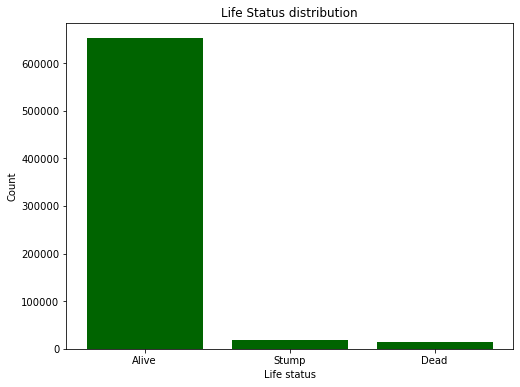

In [5]:
bardata = treedf['status'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(bardata.index, bardata.values, color='darkgreen')
plt.xlabel('Life status')
plt.ylabel('Count')
plt.title('Life Status distribution')
plt.show()

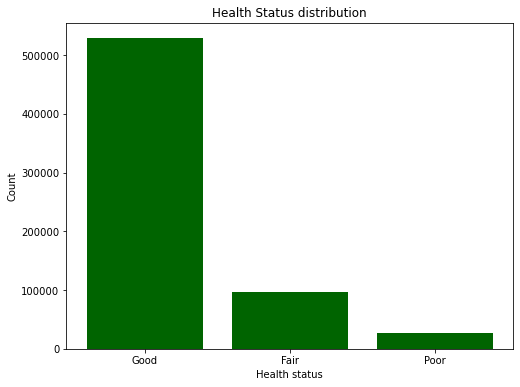

In [6]:
bardata2 = treedf['health'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(bardata2.index, bardata2.values, color='darkgreen')
plt.xlabel('Health status')
plt.ylabel('Count')
plt.title('Health Status distribution')
plt.show()

In [7]:
treeprobsgraph = treedf['problems'].apply(lambda x: 'Normal' if x is None or x == 'None' else 'Problem identified')

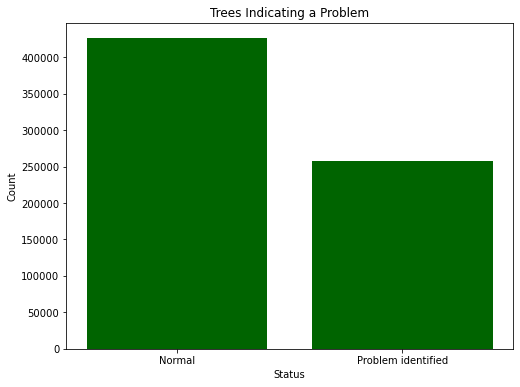

In [8]:
data3 = treeprobsgraph.value_counts()
plt.figure(figsize=(8, 6))
plt.bar(data3.index, data3.values, color='darkgreen')
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Trees Indicating a Problem')
plt.show()

## Processing the main dataframe for models

In [9]:
treedf['status'].value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [10]:
treedf['problems'].value_counts()

None                                                              426280
Stones                                                             95673
BranchLights                                                       29452
Stones,BranchLights                                                17808
RootOther                                                          11418
                                                                   ...  
TrunkLights,TrunkOther,BranchOther                                     1
Stones,MetalGrates,RootOther,WiresRope,TrunkOther,BranchLights         1
MetalGrates,TrunkOther,BranchLights,BranchOther                        1
MetalGrates,RootOther,TrunkLights,TrunkOther                           1
Stones,MetalGrates,RootOther,WiresRope,BranchLights                    1
Name: problems, Length: 232, dtype: int64

In [11]:
#create a "target" column, 1 is tree is good, 0 is tree needs to be replaced
treedf['target'] = treedf['status'].replace({'Alive': 1, 'Stump': 0, 'Dead': 0})

#target column whether there is a problem with a tree:
treedf['target_p'] = treedf['problems'].apply(lambda x: 0 if x is None or x == 'None' else 1)

In [12]:
treedf['target'].value_counts()

1    652173
0     31615
Name: target, dtype: int64

In [13]:
treedf['target_p'].value_counts()

0    426280
1    257508
Name: target_p, dtype: int64

In [14]:
#manual imputing of the data - no need to keep it in original values:
treedf['root_stone'] = treedf['root_stone'].replace({'Yes': 1, 'No': 0})
treedf['root_grate'] = treedf['root_grate'].replace({'Yes': 1, 'No': 0})
treedf['health'] = treedf['health'].replace({'Good': 3, 'Fair': 2, 'Poor': 1})

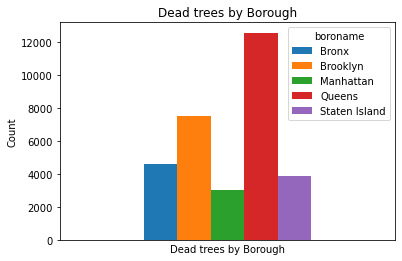

In [15]:
#brief EDA on trees where target value is "dead/stump"
dead_bar = treedf[treedf['target']==0].groupby('target')['boroname'].value_counts()

dead_bar.unstack().plot(kind='bar')
plt.xlabel('Dead trees by Borough')
plt.ylabel('Count')
plt.xticks([])
plt.title('Dead trees by Borough')

# Show the plot
plt.show()

## Building the first model

In [16]:
#Writing functions to process the data - this is fairly standard across model types?

def train_process(trainset, categoricalx, numericx, classifiersx, ohex, ssx):

    #creating dummies
    train_dummies = ohex.fit_transform(trainset[categoricalx])
    # Creating the new Dataframe from OneHotEncoder
    X_train_onehot = pd.DataFrame(train_dummies, columns=ohex.get_feature_names_out(categoricalx), index=trainset.index)
    # Apply StandardScaler to the specified numeric columns
    trainset[numericx] = ssx.fit_transform(trainset[numericx])
    #concatenate the processed datasets
    X_train_df = pd.concat([trainset[numericx], X_train_onehot, trainset[classifiersx]], axis=1)
    
    return X_train_df

def test_process(testset, categoricalx, numericx, classifiersx, ohex, ssx):
    #creating dummies
    test_dummies = ohex.transform(testset[categoricalx])
    # Creating the new Dataframe from OneHotEncoder
    X_test_onehot = pd.DataFrame(test_dummies, columns=ohex.get_feature_names_out(categoricalx), index=testset.index)
    # Apply StandardScaler to the specified numeric columns
    testset[numericx] = ssx.transform(testset[numericx])
    #concatenate the processed datasets
    X_test_df = pd.concat([testset[numericx], X_test_onehot, testset[classifiersx]], axis=1)
    
    return X_test_df


In [17]:
#deciding which columns to keep
log_df = treedf.copy()

categorical = ['guards', 'steward', 'boroname', 'spc_common'] #'cb_num', 'block_id', 
numeric = ['tree_dbh', 'Latitude', 'longitude']
classifiers = ['root_stone', 'root_grate', 'health', 'target_p']
target = ['target']
columns = categorical + numeric + classifiers + target

#create a subset DataFrame
log_df = log_df[columns]

#quick filter on blocks with more than 20 trees - did not end up using this, but keeping for future analyses
#block_id_counts = log_df3['block_id'].value_counts()
#log_df = log_df[log_df['block_id'].isin(block_id_counts.index[block_id_counts >= 20])]

#drop missing values
log_df['steward'] = log_df['steward'].fillna('No_Steward')
log_df['spc_common'] = log_df['spc_common'].fillna('Not_Avail')
#log_df['problems'] = log_df['problems'].fillna('No_problems')
log_df['health'] = log_df['health'].fillna(0)
log_df['guards'] = log_df['guards'].fillna('Unknown')

#ensure no missing values
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   guards      683788 non-null  object 
 1   steward     683788 non-null  object 
 2   boroname    683788 non-null  object 
 3   spc_common  683788 non-null  object 
 4   tree_dbh    683788 non-null  int64  
 5   Latitude    683788 non-null  float64
 6   longitude   683788 non-null  float64
 7   root_stone  683788 non-null  int64  
 8   root_grate  683788 non-null  int64  
 9   health      683788 non-null  float64
 10  target_p    683788 non-null  int64  
 11  target      683788 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 62.6+ MB


In [18]:
#define the X and y variables
X = log_df.drop(target, axis=1)
y = log_df[target]

#do a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

#instantiate a new standard scaler and one-hot encoder
ss = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore", drop = 'first', sparse = False)

# Convert 'None' strings to a unique label using LabelEncoder - only needed when error is thrown by processing functions,
#keeping for future analyses
#label_encoder = LabelEncoder()

# Apply label encoding to each column in the DataFrame - see note above
#for column in X_train.columns:
#    if X_train[column].dtype == 'O':  # Check if column contains object (string) data type
 #       X_train[column] = label_encoder.fit_transform(X_train[column])

#running the SMOTE - given large dataset, not needed.
#smote = SMOTE(random_state=53)
#X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)      

In [19]:
X_train_df = train_process(X_train, categorical, numeric, classifiers, ohe, ss)
X_test_df = test_process(X_test, categorical, numeric, classifiers, ohe, ss)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
X_train_df

,tree_dbh,Latitude,longitude,guards_Helpful,guards_None,guards_Unknown,guards_Unsure,steward_3or4,steward_4orMore,steward_No_Steward,...,spc_common_two-winged silverbell,spc_common_weeping willow,spc_common_white ash,spc_common_white oak,spc_common_white pine,spc_common_willow oak,root_stone,root_grate,health,target_p
388930,-0.606654,-0.776401,-1.880071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3.0,0
668243,-0.836171,-1.334534,0.768239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,0
406827,0.426172,-0.849981,-0.455524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,3.0,1
421211,0.999965,0.545221,1.073628,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,3.0,1
300720,-0.950930,1.704516,1.082277,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216253,-0.377137,-2.184911,-2.573171,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3.0,0
177915,1.229482,-0.861320,-0.097740,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,2.0,1
317861,-0.606654,1.140619,-0.175556,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3.0,0
559989,-0.950930,-0.752730,-0.346102,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,3.0,0


In [21]:
# Create the logistic regression object
log = LogisticRegression()

# Train the logistic regression model
clf = log.fit(X_train_df, y_train)

# Predict the target class based on p > 0.5 criteria
y_pred = clf.predict(X_train_df)

# Predict the probability with the training data set
clf.predict_proba(X_train_df)

# Calculate the model fit
acc1 = clf.score(X_train_df, y_train)
recall1 = recall_score(y_train, y_pred)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


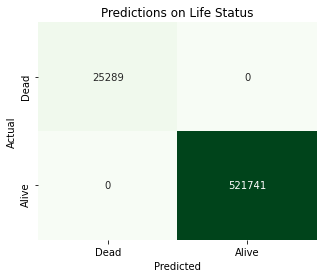

In [22]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Dead', 'Alive'],
            yticklabels=['Dead', 'Alive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predictions on Life Status')
plt.show()

Clearly, the model has something going on.

...Turns out, almost no data is recorded for dead trees & stumps. Need to find another target variable.

### Model #2 - changing the target variable

In [23]:
#model 2 - there has to be a better way to streamline this...

categorical2 = ['steward', 'spc_common', 'status', 'cb_num', 'boroname']
numeric2 = ['tree_dbh', 'Latitude', 'longitude']
classifiers2 = ['health']
target2 = ['target_p']
columns2 = categorical2 + numeric2 + classifiers2 + target2

#create a subset DataFrame
log_df2 = treedf[columns2]

#ensure no missing values
log_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   steward     652173 non-null  object 
 1   spc_common  652169 non-null  object 
 2   status      683788 non-null  object 
 3   cb_num      683788 non-null  int64  
 4   boroname    683788 non-null  object 
 5   tree_dbh    683788 non-null  int64  
 6   Latitude    683788 non-null  float64
 7   longitude   683788 non-null  float64
 8   health      652172 non-null  float64
 9   target_p    683788 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 52.2+ MB


In [24]:
#fill na values
log_df2['steward'] = log_df2['steward'].fillna('No_Steward')
log_df2['health'] = log_df2['health'].fillna(0)
log_df2['spc_common'] = log_df2['spc_common'].fillna('Not_Avail')

<ipython-input-24-df0909064b44>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df2['steward'] = log_df2['steward'].fillna('No_Steward')
<ipython-input-24-df0909064b44>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df2['health'] = log_df2['health'].fillna(0)
<ipython-input-24-df0909064b44>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [25]:
log_df2['health'].value_counts()


3.0    528850
2.0     96504
0.0     31616
1.0     26818
Name: health, dtype: int64

In [26]:
#define the X and y variables
X2 = log_df2.drop(target2, axis=1)
y2 = log_df2[target2]

#do a train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=53)

In [27]:
#instantiate a new standard scaler and one-hot encoder
ss2 = StandardScaler()
ohe2 = OneHotEncoder(handle_unknown="ignore", drop = 'first', sparse = False)

#run pre-processing functions
X_train_df2 = train_process(X_train2, categorical2, numeric2, classifiers2, ohe2, ss2)
X_test_df2 = test_process(X_test2, categorical2, numeric2, classifiers2, ohe2, ss2)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
# Create the logistic regression object
log2 = LogisticRegression(max_iter=1000)

# Train the logistic regression model
clf2 = log2.fit(X_train_df2, y_train2)

# Predict the target class based on p > 0.5 criteria
y_pred2 = clf2.predict(X_train_df2)

# Predict the probability with the training data set
clf2.predict_proba(X_train_df2)

# Calculate the model fit
acc2 = clf2.score(X_train_df2, y_train2)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
recall2 = recall_score(y_train2, y_pred2)
print('accuracy: '+str(acc2)+' -----  recall: '+str(recall2))

accuracy: 0.7222254720947663 -----  recall: 0.4767634552302272


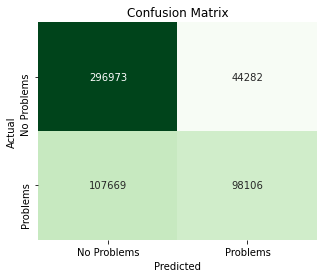

In [30]:
# Calculate the confusion matrix
conf_matrix2 = confusion_matrix(y_train2, y_pred2)
labels = ('No Problems', 'Problems')
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Problems', 'Problems'],
            yticklabels=['No Problems', 'Problems'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ok, this model seems to be running average at best. Going to add more columns to see if we can reduce the false positives...

### Model #3 - add other columns

In [31]:
#model 3 - there has to be a better way to streamline this...

categorical3 = ['guards', 'steward', 'boroname', 'spc_common', 'cb_num', 'status', 'sidewalk', 'user_type', 'cncldist']
numeric3 = ['tree_dbh', 'Latitude', 'longitude']
classifiers3 = ['root_stone', 'root_grate']
target3 = ['target_p']
columns3 = categorical3 + numeric3 + classifiers3 + target3

#create a subset DataFrame
log_df3 = treedf[columns3]

#ensure no missing values
log_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   guards      652172 non-null  object 
 1   steward     652173 non-null  object 
 2   boroname    683788 non-null  object 
 3   spc_common  652169 non-null  object 
 4   cb_num      683788 non-null  int64  
 5   status      683788 non-null  object 
 6   sidewalk    652172 non-null  object 
 7   user_type   683788 non-null  object 
 8   cncldist    683788 non-null  int64  
 9   tree_dbh    683788 non-null  int64  
 10  Latitude    683788 non-null  float64
 11  longitude   683788 non-null  float64
 12  root_stone  683788 non-null  int64  
 13  root_grate  683788 non-null  int64  
 14  target_p    683788 non-null  int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 78.3+ MB


In [32]:
#fill in null values
log_df3['guards'] = log_df3['guards'].fillna('Unknown')
log_df3['steward'] = log_df3['steward'].fillna('No_Steward')
log_df3['spc_common'] = log_df3['spc_common'].fillna('Not_Avail')
log_df3['sidewalk'] = log_df3['sidewalk'].fillna('No_issue')

<ipython-input-32-b034f7b3f9d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df3['guards'] = log_df3['guards'].fillna('Unknown')
<ipython-input-32-b034f7b3f9d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df3['steward'] = log_df3['steward'].fillna('No_Steward')
<ipython-input-32-b034f7b3f9d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [33]:
log_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   guards      683788 non-null  object 
 1   steward     683788 non-null  object 
 2   boroname    683788 non-null  object 
 3   spc_common  683788 non-null  object 
 4   cb_num      683788 non-null  int64  
 5   status      683788 non-null  object 
 6   sidewalk    683788 non-null  object 
 7   user_type   683788 non-null  object 
 8   cncldist    683788 non-null  int64  
 9   tree_dbh    683788 non-null  int64  
 10  Latitude    683788 non-null  float64
 11  longitude   683788 non-null  float64
 12  root_stone  683788 non-null  int64  
 13  root_grate  683788 non-null  int64  
 14  target_p    683788 non-null  int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 78.3+ MB


In [34]:
#Instantiate transformers
ss3 = StandardScaler()
ohe3 = OneHotEncoder(handle_unknown="ignore", drop = 'first', sparse = False)

#define the X and y variables
X3 = log_df3.drop(target3, axis=1)
y3 = log_df3[target3]

#do a train-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=53)

In [35]:
#run the processing functions:
X_train_df3 = train_process(X_train3, categorical3, numeric3, classifiers3, ohe3, ss3)
X_test_df3 = test_process(X_test3, categorical3, numeric3, classifiers3, ohe3, ss3)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [36]:
X_train_df3.shape

(547030, 263)

In [37]:
# Create the logistic regression object
log3 = LogisticRegression(max_iter=10000, n_jobs=8)#, penalty='l1', solver='liblinear')

# Train the logistic regression model
clf3 = log3.fit(X_train_df3, y_train3)

# Predict the target class based on p > 0.5 criteria
y_pred3 = clf3.predict(X_train_df3)

# Predict the probability with the training data set
clf3.predict_proba(X_train_df3)

# Calculate the model fit
acc3 = clf3.score(X_train_df3, y_train3)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
recall3 = recall_score(y_train3, y_pred3)
print('accuracy: '+str(acc3)+' -----  recall: '+str(recall3)+' -----  precision: '+str(precision_score(y_train3, y_pred3)))

accuracy: 0.8801564813629965 -----  recall: 0.6980828574899769 -----  precision: 0.976672400546645


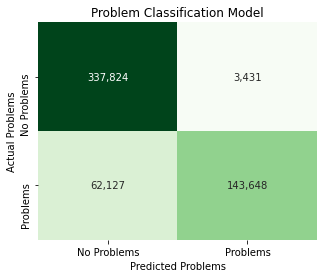

In [39]:
conf_matrix3 = confusion_matrix(y_train3, y_pred3,)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix3, annot=True, cmap='Greens', cbar=False, fmt=',',
            xticklabels=['No Problems', 'Problems'],
            yticklabels=['No Problems', 'Problems'])
plt.xlabel('Predicted Problems')
plt.ylabel('Actual Problems')
plt.title('Problem Classification Model')
plt.show()

#### this base-model has the highest accuracy so far, so we will tune the hyper-parameters along these columns. Using notation '--3a' for future models to prevent data-leakage.

- Next step is to try balancing the data
- Then, try tuning hyper-parameters

##### after running into memory issues running the model, we need to down-sample the majority class. once the model runs successfully, will tune the amount of data to increase as much as possible before running into the memory issue

In [40]:
# Separate majority and minority classes
majority_class = log_df3[log_df3['target_p'] == 0]
minority_class = log_df3[log_df3['target_p'] == 1]

# Downsample majority class
downsampled_majority = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=53)

# Combine the dataframes
balanced_df = pd.concat([downsampled_majority, minority_class])

# Shuffle the rows
log_df3_bal = balanced_df.sample(frac=1, random_state=53).reset_index(drop=True)

In [41]:
log_df3_bal['target_p'].value_counts()

1    257508
0    257508
Name: target_p, dtype: int64

In [42]:
#Instantiate transformers
ss3a = StandardScaler()
ohe3a = OneHotEncoder(handle_unknown="ignore", drop = 'first', sparse = False)

#define the X and y variables
X3a = log_df3_bal.drop(target3, axis=1)
y3a = log_df3_bal[target3]

#do a train-test split
X_train3a, X_test3a, y_train3a, y_test3a = train_test_split(X3a, y3a, test_size=0.2, random_state=53)

In [43]:
#run the processing functions:
X_train_df3a = train_process(X_train3a, categorical3, numeric3, classifiers3, ohe3a, ss3a)
X_test_df3a = test_process(X_test3a, categorical3, numeric3, classifiers3, ohe3a, ss3a)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [44]:
X_train_df3a.shape

(412012, 263)

In [45]:
# Create the logistic regression object
log3a = LogisticRegression(max_iter=10000, n_jobs=8)

# Train the logistic regression model
clf3a = log3a.fit(X_train_df3a, y_train3a)

# Predict the target class based on p > 0.5 criteria
y_pred3a = clf3a.predict(X_train_df3a)

# Predict the probability with the training data set
clf3a.predict_proba(X_train_df3a)

# Calculate the model fit
acc3a = clf3a.score(X_train_df3a, y_train3a)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
recall3a = recall_score(y_train3a, y_pred3a)
print('accuracy: '+str(acc3a)+' -----  recall: '+str(recall3a))

accuracy: 0.8478976340494937 -----  recall: 0.7358698608844331


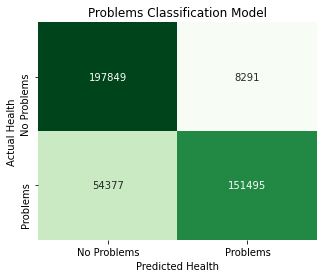

In [47]:
conf_matrix3a = confusion_matrix(y_train3a, y_pred3a)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix3a, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Problems', 'Problems'],
            yticklabels=['No Problems', 'Problems'])
plt.xlabel('Predicted Health')
plt.ylabel('Actual Health')
plt.title('Problems Classification Model')
plt.show()

##### Balancing the dataset did not help the model, so we will continue with the unbalanced dataset.

#### Tuning hyper-parameters on model #3

In [48]:
#starting with C-value
#do a train-test split
X_train3b, X_test3b, y_train3b, y_test3b = train_test_split(X3, y3, test_size=0.2, random_state=53)

#set new processors
ss3b = StandardScaler()
ohe3b = OneHotEncoder(handle_unknown="ignore", drop = 'first', sparse = False)

#run the processing functions:
X_train_df3b = train_process(X_train3b, categorical3, numeric3, classifiers3, ohe3b, ss3b)
X_test_df3b = test_process(X_test3b, categorical3, numeric3, classifiers3, ohe3b, ss3b)



C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [49]:
X_train_df3b.shape

(547030, 263)

In [50]:
# Create the logistic regression object
log3b = LogisticRegression(max_iter=10000, n_jobs=8, C=100)

# Train the logistic regression model
clf3b = log3b.fit(X_train_df3b, y_train3b)

# Predict the target class based on p > 0.5 criteria
y_pred3b = clf3b.predict(X_train_df3b)

# Predict the probability with the training data set
prob3b = clf3b.predict_proba(X_train_df3b)

# Calculate the model fit
acc3b = clf3b.score(X_train_df3b, y_train3b)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
recall3b = recall_score(y_train3b, y_pred3b)
print('accuracy: '+str(acc3b)+' -----  recall: '+str(recall3b))

accuracy: 0.8801692777361387 -----  recall: 0.6982043494107641


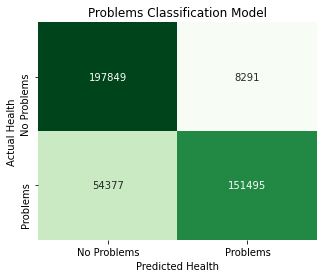

In [52]:
conf_matrix3b = confusion_matrix(y_train3b, y_pred3b)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix3a, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Problems', 'Problems'],
            yticklabels=['No Problems', 'Problems'])
plt.xlabel('Predicted Health')
plt.ylabel('Actual Health')
plt.title('Problems Classification Model')
plt.show()

##### Changing C worked better, now shifting from lasso to ridge penalty:

In [53]:
#set C to 100
#next hyper-parameter: change from l2 to l1 penalty
#do a train-test split
X_train3c, X_test3c, y_train3c, y_test3c = train_test_split(X3, y3, test_size=0.2, random_state=53)

#set new processors
ss3c = StandardScaler()
ohe3c = OneHotEncoder(handle_unknown="ignore", drop = 'first', sparse = False)

X_train_df3c = train_process(X_train3c, categorical3, numeric3, classifiers3, ohe3c, ss3c)
X_test_df3c = test_process(X_test3c, categorical3, numeric3, classifiers3, ohe3c, ss3c)

# Create the logistic regression object with penalty l1
log3c = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear', C=100)

# Train the logistic regression model
clf3c = log3c.fit(X_train_df3c, y_train3c)
# Predict the target class based on p > 0.5 criteria
y_pred3c = clf3c.predict(X_train_df3c)
# Predict the probability with the training data set
clf3c.predict_proba(X_train_df3c)
# Calculate the model fit
acc3c = clf3c.score(X_train_df3c, y_train3c)


C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
recall3c = recall_score(y_train3c, y_pred3c)
print('accuracy: '+str(acc3c)+' -----  recall: '+str(recall3c))

accuracy: 0.8801674496828328 -----  recall: 0.6981897703802697


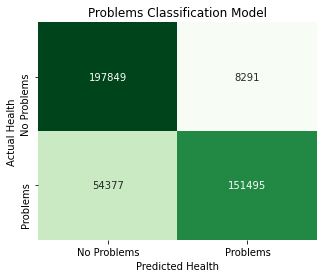

In [55]:
conf_matrix3b = confusion_matrix(y_train3b, y_pred3b)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix3a, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Problems', 'Problems'],
            yticklabels=['No Problems', 'Problems'])
plt.xlabel('Predicted Health')
plt.ylabel('Actual Health')
plt.title('Problems Classification Model')
plt.show()

##### No material change between ridge and lasso penalties, will stick with lasso for simplicity. Checking cross-validation as a final measure

In [56]:
#check cross-validation
log3d = LogisticRegression(max_iter=10000)

#do a train-test split
X_train3d, X_test3d, y_train3d, y_test3d = train_test_split(X3, y3, test_size=0.2, random_state=53)

#set new processors
ss3d = StandardScaler()
ohe3d = OneHotEncoder(handle_unknown="ignore", drop = 'first', sparse = False)

#run the processing functions:
X_train_df3d = train_process(X_train3d, categorical3, numeric3, classifiers3, ohe3d, ss3d)
X_test_df3d = test_process(X_test3d, categorical3, numeric3, classifiers3, ohe3d, ss3d)

#5-fold cross-validation
log3d = LogisticRegression(max_iter=10000, n_jobs=8, C=100)
scores = cross_validate(log3d, X_train_df3d, y_train3d, cv=5, n_jobs=8)

# Print cross-validation scores and mean score
print("Cross-Validation Scores:", scores)

C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Cross-Validation Scores: {'fit_time': array([332.80013156, 371.11125803,  40.2144196 , 412.00748277,
       395.5266819 ]), 'score_time': array([0.62764955, 0.53343058, 0.        , 0.42180777, 0.4061532 ]), 'test_score': array([0.87909255, 0.87970495,        nan, 0.87968667, 0.88103943])}


C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Reid Majka\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 

### Try a Decision Tree classifier on model #3

In [57]:
tree_df = log_df3.copy()

In [58]:
# Convert 'None' strings to a unique label using LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each column in the DataFrame
for column in tree_df.columns:
    if tree_df[column].dtype == 'O':  # Check if the column contains object (string) data type
        tree_df[column] = label_encoder.fit_transform(tree_df[column])

In [59]:
#define the X and y variables
X4 = tree_df.drop(target3, axis=1)
y4 = tree_df[target3]

#do a train-test split
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=53)

tree_clf = DecisionTreeClassifier(criterion = 'gini', max_depth=5, random_state=53)

tree_clf.fit(X_train4, y_train4)

DecisionTreeClassifier(max_depth=5, random_state=53)

In [60]:
X_train4.shape

(547030, 14)

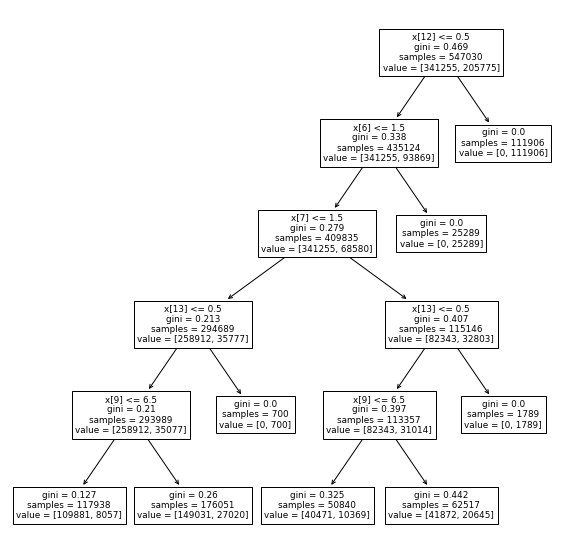

In [61]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_clf, ax=ax);

In [62]:
y_pred4 = tree_clf.predict(X_train4)
acc4 = accuracy_score(y_train4, y_pred4)
recall4 = recall_score(y_train4, y_pred4)

In [63]:
y_pred4 = tree_clf.predict(X_train4)
y_pred4

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [64]:
acc = accuracy_score(y_train4, y_pred4) * 100
rec4 = recall_score(y_train4, y_pred4)
print("Accuracy: {0}".format(acc))
print("Recall: {0}".format(rec4))

Accuracy: 87.91821289508802
Recall: 0.6788190985299477


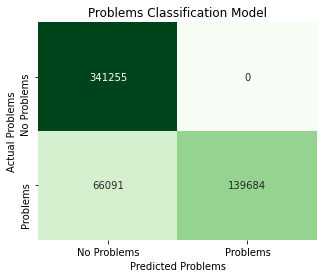

In [65]:
conf_matrix4 = confusion_matrix(y_train4, y_pred4)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix4, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Problems', 'Problems'],
            yticklabels=['No Problems', 'Problems'])
plt.xlabel('Predicted Problems')
plt.ylabel('Actual Problems')
plt.title('Problems Classification Model')
plt.show()

## Conclusion: 

the tuned logistic regression model #3 produces the highest scores, lets take a look in summary:

In [66]:
scorestot = [('model1', acc1, recall1), ('model2', acc2, recall2), ('model3', acc3, recall3), ('model3a', acc3a, recall3a), 
 ('model3b', acc3b, recall3b), ('model3c', acc3c, recall3c), ('model4', acc4, recall4)]
for (name, x, y) in scorestot:
    print(name+' accuracy: '+str(x)+' -----  recall: '+str(y))

model1 accuracy: 1.0 -----  recall: 1.0
model2 accuracy: 0.7222254720947663 -----  recall: 0.4767634552302272
model3 accuracy: 0.8801564813629965 -----  recall: 0.6980828574899769
model3a accuracy: 0.8478976340494937 -----  recall: 0.7358698608844331
model3b accuracy: 0.8801692777361387 -----  recall: 0.6982043494107641
model3c accuracy: 0.8801674496828328 -----  recall: 0.6981897703802697
model4 accuracy: 0.8791821289508802 -----  recall: 0.6788190985299477


In [67]:
#using model 3b, attempt to increase recall
threshold = [0.45, 0.4, 0.35, 0.3, 0.25, 0.2]

for x in threshold:
    predictions = (prob3b[:, 1] > x).astype(int)
    # Calculate accuracy using the adjusted threshold
    accuracy_scores = accuracy_score(y_train3b, predictions)
    recall_scores = recall_score(y_train3b, predictions)
    precision_scores = precision_score(y_train3b, predictions)
    print("Accuracy with adjusted threshold of "+str(x)+": {:.2f}".format(accuracy_scores))
    print("Recall with adjusted threshold of "+str(x)+": {:.2f}".format(recall_scores))
    print("Precision with adjusted threshold of "+str(x)+": {:.2f}".format(precision_scores))
    print('----------------')

Accuracy with adjusted threshold of 0.45: 0.88
Recall with adjusted threshold of 0.45: 0.71
Precision with adjusted threshold of 0.45: 0.96
----------------
Accuracy with adjusted threshold of 0.4: 0.88
Recall with adjusted threshold of 0.4: 0.73
Precision with adjusted threshold of 0.4: 0.93
----------------
Accuracy with adjusted threshold of 0.35: 0.87
Recall with adjusted threshold of 0.35: 0.75
Precision with adjusted threshold of 0.35: 0.90
----------------
Accuracy with adjusted threshold of 0.3: 0.86
Recall with adjusted threshold of 0.3: 0.77
Precision with adjusted threshold of 0.3: 0.85
----------------
Accuracy with adjusted threshold of 0.25: 0.84
Recall with adjusted threshold of 0.25: 0.81
Precision with adjusted threshold of 0.25: 0.78
----------------
Accuracy with adjusted threshold of 0.2: 0.81
Recall with adjusted threshold of 0.2: 0.85
Precision with adjusted threshold of 0.2: 0.70
----------------


Ok, lowering the threshold keeps accuracy relatively stable, and increases recall, but lowers precision. this is intuitive. So we are going to run the model one last time with a threshold of 0.35 to maintain an "A+" precision, while raising recall:

In [68]:
#time to run through the test data!
# Predict the target class based on p > 0.5 criteria
y_pred3bFINAL = clf3b.predict(X_test_df3b)

# Predict the probability with the training data set
prob3bFINAL = clf3b.predict_proba(X_test_df3b)

# Calculate the model fit
acc3bFINAL = clf3b.score(X_test_df3b, y_test3b)

recall3bFINAL = recall_score(y_test3b, y_pred3bFINAL)
print('accuracy: '+str(acc3bFINAL)+' -----  recall: '+str(recall3bFINAL))

accuracy: 0.87914418169321 -----  recall: 0.6960547426207643


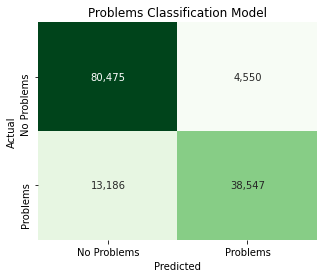

In [69]:
#get final y_pred's on a 0.35 threshold:
y_pred3b_final = (prob3bFINAL[:, 1] > 0.35).astype(int)
conf_matrix3b_final = confusion_matrix(y_test3b, y_pred3b_final)

#creating the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix3b_final, annot=True, fmt=',', cmap='Greens', cbar=False,
            xticklabels=['No Problems', 'Problems'],
            yticklabels=['No Problems', 'Problems'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Problems Classification Model')
plt.show()

In [70]:
#find the column with the highest weight
X_train_df3b.columns[np.argmax(np.abs(clf3b.coef_))]

'root_stone'